In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

- Выбор датасетов:

In [5]:
df = pd.read_csv("../res/california_housing_train.csv")

- Получите и визуализируйте статистику по датасету (включая количество, среднее значение, стандартное отклонение, минимум, максимум и различные квантили).

Проверим, загрузилось ли и посмотрим, какие именно данные у нас есть

In [6]:
df.sample(n=5, random_state=42)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10941,-120.87,37.77,9.0,4838.0,920.0,2460.0,923.0,3.5959,142700.0
5250,-118.14,34.11,52.0,2742.0,422.0,1153.0,414.0,8.1124,500001.0
10292,-120.05,36.98,16.0,3705.0,739.0,2463.0,697.0,2.5288,61800.0
2266,-117.42,34.02,9.0,5455.0,882.0,3015.0,858.0,4.2321,162800.0
6398,-118.26,33.97,52.0,1331.0,346.0,1144.0,362.0,1.5326,90600.0


In [8]:
df.info() # Что по распознанным типам?
df.describe() # Статистики по данным

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


> как видим, чинить распознанные типы не нужно

- Проведите предварительную обработку данных, включая обработку отсутствующих
  значений, кодирование категориальных признаков и нормировка.

In [9]:
df.isna().values.any() # есть пропуски?

False

> Типы распознаны, NaN'ов нет, все данные численные. Так что дополнительная обработка не нужна.

У нас же есть широта и долгота :thinking:... Давайте изобразим

<Axes: >

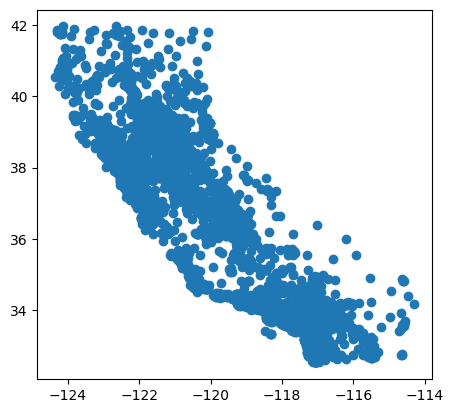

In [7]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
gdf.plot()

И правда похоже на Калифорнию :star_struck:

- Разделите данные на обучающий и тестовый наборы данных.

In [10]:
from pandas import DataFrame
def my_train_test_split(
    *dataframes: DataFrame, 
    test_size: float=None, 
    random_state: float=None
) -> list[DataFrame]:
    if test_size is None:
        return dataframes
    if test_size < 0 or 1 < test_size:
        raise ValueError("`train_size` must be a partial in range (0, 1)")
    
    res = [None for _ in range(len(dataframes) * 2)]
    for i, df in enumerate(dataframes):
        test_data_size = int(len(df) * test_size)
        indices = pd.Series(np.arange(0, len(df), 1))
        test_indices = indices.sample(test_data_size, random_state=random_state)
        test_data = df.iloc[test_indices]
        train_data = df.iloc[indices.drop(test_indices)]
        res[i * 2], res[i * 2 + 1] = train_data, test_data
    return res

In [11]:
df_train, df_test = my_train_test_split(df, test_size=0.3, random_state=42)

- Реализуйте линейную регрессию с использованием метода наименьших квадратов без
использования сторонних библиотек, кроме `NumPy` и `Pandas`. Использовать
минимизацию суммы квадратов разностей между фактическими и предсказанными
значениями для нахождения оптимальных коэффициентов.

# Линейная регрессия

Линейные методы предполагают, что между признаками объекта и целевой переменной существует линейная зависимость, то есть
$$
    y = w_1 x_1 + w_2 x_2 + ... + w_k x_k + b,
$$
где $у$ — целевая переменная, $x_i$ — признак объекта $х$, $w_i$ — вес $i$-го признака, $b$ — bias (смещение, свободный член)

Часто предполагают, что объект $х$ содержит в себе фиктивный признак равный 1 для представления свободного члена $b$. В этом случае формула принимает простой вид:
$$
    y = \langle w, x \rangle,
$$
где $\langle \cdot, \cdot \rangle$ — скалярное произведение векторов $w, x \in \mathbb{R}^n$.

В матричной форме, в случае, когда у нас есть $m$ объектов формулу можно переписать следующим образом:
$$
    Y = Xw, 
$$
где $Y$ — столбец размера $n$, $X$ — матрица признаков размера $n \times k$, $w$ — вектор весов размера $k$.

**Лосс:**
$$
\begin{aligned}
L(y_{pred}, Y) &= \frac{1}{n}||y_{pred} - Y||^2_2 =\\
&= \frac{1}{n}||Xw - Y||^2_2 = \frac{1}{n}\sum_{i=1}^{n}\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 =: L(w)
\end{aligned}
$$

## Аналитическое решение

Минимизация ошибки по методу наименьших квадратов дает решение: 
$$
    w = (X^TX)^{-1}X^TY 
$$

Реализуем класс линейной регрессии с помощью этой формулы.

In [12]:
from pandas import DataFrame
from typing import Self
class MyLinearRegression(object):
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X: DataFrame, y: DataFrame) -> Self:
        n, k = X.shape
        X_train = X.values if not self.fit_intercept else np.hstack((X.values, np.ones((n, 1))))

        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y.values

        return self
    
    def predict(self, X: DataFrame) -> DataFrame:
        n, k = X.shape
        
        X_train = X.values if not self.fit_intercept else np.hstack((X.values, np.ones((n,1))))
        return X_train @ self.w

In [13]:
def linear_expression(x):
    return 5 * x + 6
objects_num = 50
X_data = np.linspace(-5, 5, objects_num)
y_data = linear_expression(X_data) + np.random.randn(objects_num) * 5

X = pd.DataFrame(X_data)
y = pd.DataFrame(y_data)

X_train, X_test, y_train, y_test = my_train_test_split(X, y, test_size=0.5, random_state=4)


In [14]:
y_pred = MyLinearRegression().fit(X_train, y_train).predict(X_test)

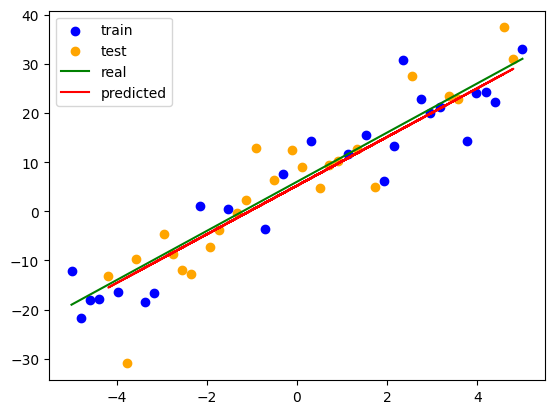

In [15]:
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')
plt.plot(X_data, linear_expression(X_data), label='real', c='g')
plt.plot(X_test, y_pred, label='predicted', c='r')
plt.legend()
plt.show()

- Постройте **три модели** с различными наборами признаков.



interval columns not set, guessing: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']


<Axes: >

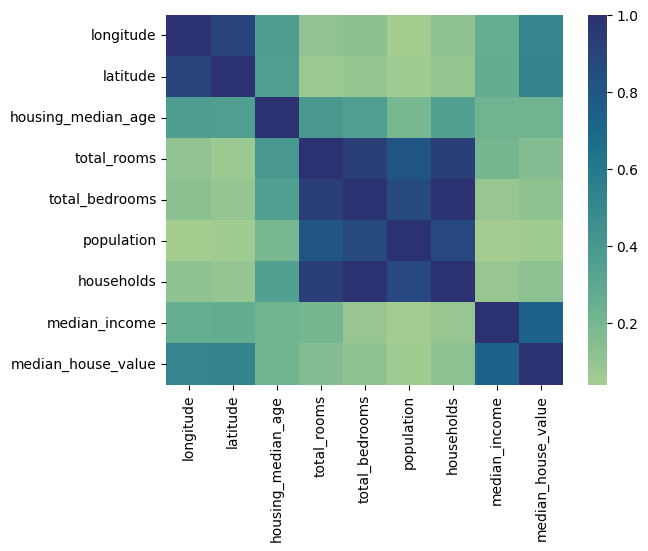

In [16]:
sns.heatmap(df.phik_matrix(), cmap='crest')

- Для каждой модели проведите оценку производительности, используя метрику
  коэффициент детерминации, чтобы измерить, насколько хорошо модель
  соответствует данным.



- Сравните результаты трех моделей и сделайте выводы о том, какие признаки
  работают лучше всего для каждой модели.



- Бонусное задание
    - Ввести синтетический признак при построении модели
